# Code for sparse coding of spectrotemporal data
*Nhat Le, Sep 2017*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import scipy.io.wavfile
import scipy.signal
import glob
import skimage.io
from sklearn.decomposition import PCA
import seaborn as sns
import os.path

%matplotlib inline

## Core functions for updating s and A

In [2]:
def T(u, lamb, norm_type):
    '''Threshold function with the appropriate norm type (L0 or L1)'''
    if norm_type == 'L0':
        return max(u, 0.0)
    elif norm_type == 'L1':
        return max(u - lamb, 0.0)
    else:
        raise ValueError('Invalid norm type')

# Vectorized version of T        
T_vec = np.vectorize(T)
    
def find_s(tau, A, y, lamb, niter=100, update='paper', verbose=False):
    '''Perform LCA to find the sparse representation s, given a dictionary
    of features, A, and target y. Returns optimal s, and best cost.
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    # Initialize
    best_cost = np.inf
    cost_prev = np.inf
    y = y[:, np.newaxis]
    s = np.zeros((A.shape[1], 1), dtype='float')
    best_s = np.zeros((A.shape[1], 1), dtype='float')
    u = np.zeros((A.shape[1], 1), dtype='float')
    
    # Start competition
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            s += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, y) - np.dot(np.dot(A.T, A), s) - np.sign(s)
            
            u += du * tau
            print(u)
            s = T_vec(u, lamb, norm_type='L1')
            print(s)
            
        cost = 0.5 * np.linalg.norm(y - np.dot(A, s))**2 + lamb * np.linalg.norm(s, ord=1)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_s = s
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost, 'Best s =', best_s.T)
    return best_s, best_cost


def find_s_batch(tau, A, Y, lamb, niter=100, update='paper', verbose=False):
    '''Find s for each target, given a collection of targets Y.
    Returns a matrix S: n_neurons x n_targets, and the best cost
    lamb: weight of sparsity constraint 
    tau: learning rate'''
    best_cost = np.inf
    cost_prev = np.inf
    S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    best_S = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    U = np.zeros((A.shape[1], Y.shape[1]), dtype='float')
    for i in range(niter):
        print('Starting iteration #', i, '...')
        if update == 'direct':
            ds = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            S += ds * tau
        elif update == 'paper':
            du = np.dot(A.T, Y) - np.dot(np.dot(A.T, A), S) - np.sign(S)
            
            U += du * tau
            
            S = T_vec(U, lamb, norm_type='L1')
            
        diff = (Y - np.dot(A, S)).ravel()
        cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(S.ravel(), ord=1)
        #print('cost: ', cost)
        if cost <= cost_prev:
            tau *= 1.05
        else:
            tau *= 0.5
        
        cost_prev = cost
            
        if cost < best_cost:
            best_cost = cost
            best_S = S
        
        if verbose:
            print('Cost = ', cost, '. tau =', tau)
    print('Best cost = ', best_cost)
    return best_S, best_cost

In [3]:
def learn_step(y, A, s, eta, theta):
    '''Update the dictionary A of receptive fields, given the vector s 
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    s = s[:, np.newaxis]
    y = y[:, np.newaxis]
    r = y - np.dot(A, s)
    A_new = A + eta * (np.dot(r, s.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def learn_step_batch(Y, A, S, eta, theta):
    '''Update the dictionary A of receptive fields, given the matrix S of all activity vectors,
    and Y, a matrix containing all the training examples.
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    R = Y - np.dot(A, S)
    A_new = A + eta * (np.dot(R, S.T)) + theta * (A - np.dot(A, np.dot(A.T, A)))
    return A_new

def do_multiple_learn_steps(y, A, s, eta, theta, nsteps=10, verbose=False):
    '''Perform multiple steps of learning A
    eta: learning rate to match s
    theta: learning rate used for de-correlating columns of A'''
    diff = (y - np.dot(A, s)).ravel()
    cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
    prev_cost = cost
    best_cost = cost
    A_best = A
    for i in range(nsteps):
        if y.ndim == 1: # Single example
            A = learn_step(y, A, s, eta, theta)
            cost = np.linalg.norm(y - np.dot(A, s))**2
        else: # batch
            assert(y.shape[1] == s.shape[1])
            A = learn_step_batch(y, A, s, eta, theta)
            diff = (y - np.dot(A, s)).ravel()
            cost = 0.5 * np.linalg.norm(diff)**2 + lamb * np.linalg.norm(s.ravel(), ord=1)
            #cost = np.linalg.norm(y - np.dot(A, s))**2
        if verbose:
            #print(A[0,:])
            print('Cost = ', cost, 'eta = ', eta, 'theta = ', theta)
        if cost < best_cost:
            best_cost = cost
            A_best = A
            
        if cost <= prev_cost:
            eta *= 1.05
            theta *= 1.05
        else:
            eta *= 0.5
            theta *= 0.5
        
        prev_cost = cost
    print('Best cost = ', best_cost)
        
    return A_best, best_cost

def find_optimal_A(y, s):
    '''Analytical solution for the best matrix A to match s'''
    assert(s.shape[1] == 1)
    y = y[:, np.newaxis]
    n = np.dot(s.T, s)[0,0]
    #print(s.shape, y.shape)
    return np.dot(y, 1.0 / n * s.T)

## Read sound files & compute spectrograms

In [4]:
def logfsgram(X, N=1024, SR=8000, WIN=1024, NOV=512, FMIN=80, BPO=12):
    '''Create a spectrogram whose frequency is log-sampled
    X: signal X is input signal; N is parent FFT window; SR is the source samplerate.
    WIN is actual window length within FFT, NOV is number of overlapping 
    points between successive windows.
    Optional FMIN is the lowest frequency to display (80Hz);
    BPO is the number of bins per octave (12).
    MX returns the nlogbin x nfftbin mapping matrix;
    sqrt(MX'*(Y.^2)) is an approximation to the original FFT
    spectrogram that Y is based on, suitably blurred by going 
    through the log-F domain.
    Source: dpwe@ee.columbia.edu
'''
    _,_,XX = scipy.signal.spectrogram(X, fs=SR, nfft=WIN, nperseg=N, noverlap=NOV)
    fratio = 2.0**(1 / BPO)
    nbins = np.floor(np.log((SR / 2) / FMIN) / np.log(fratio))
    fftfrqs = np.arange(N/2 + 1) * (SR / N)
    nfftbins = N/2 + 1
    logffrqs = FMIN * np.exp(np.log(2) * np.arange(nbins) / BPO)
    logfbws = logffrqs * (fratio - 1)
    logfbws = np.maximum(logfbws, SR/N)
    ovfctr = 0.5475

    replogffrqs = np.repeat(logffrqs[:,np.newaxis], nfftbins, axis=1)
    repfftfrqs = np.tile(fftfrqs, (int(nbins), 1))
    replogfbws = np.repeat(ovfctr * logfbws[:,np.newaxis], nfftbins, axis=1)

    freqdiff = (replogffrqs - repfftfrqs) / replogfbws
    mx = np.exp(-0.5 * freqdiff**2)
    divby = np.sqrt(2 * np.sum(mx**2, axis=1))
    divby = np.repeat(divby[:,np.newaxis], nfftbins, axis=1)
    mx = mx / divby
    spectrogram = np.sqrt(np.dot(mx, np.abs(XX)**2))
    return spectrogram, XX, f, t

In [5]:
def read_song_file(type):
    '''Read song files of the appropriate type.
    Returns the combined sound and the sampling rate, fs'''
    if type == 'human':
        # Read the American English files
        soundfiles = glob.glob('./American-English/*/*.wav')
        sound_combined = np.zeros(0)
        for file in soundfiles:
            fs, sound = scipy.io.wavfile.read(file)
            sound_trim = np.trim_zeros(sound)
            sound_combined = np.concatenate((sound_combined, sound_trim))
    elif type == 'finch_50':
        # Read bird song file
        fs, sound_combined = scipy.io.wavfile.read('./songs_50_test_bird_0.15s.wav')
        sound_combined = sound_combined[:,0]
    elif type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_2.wav')[:100]
        sound_combined = np.zeros(0)
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            sound_combined = np.concatenate((sound_combined, sound))
    else:
        raise ValueError('Invalid file type')
        
    return sound_combined, fs

In [14]:
def make_spectrogram_multifile(type, n):
    if type == 'pda':
        # Read the PDA data files
        soundfiles = glob.glob('./PDA/PDAm/16k/*/*_5.wav')[:n]
        t_all = np.zeros(0) # Used for time points in spectrogram
        thead = 0
        for idx, file in enumerate(soundfiles):
            print('Reading file', idx, ' of ', len(soundfiles))
            fs, sound = scipy.io.wavfile.read(file)
            f,t,spectrogram = multitaper_spec(sound, fs=fs, nadvance=100, nperseg=4096*4, slepian_len=500)
            t += thead
            t_all = np.append(t_all, t)
            if idx == 0:
                sound_combined = spectrogram
            else:
                sound_combined = np.hstack((sound_combined, spectrogram))
                
            thead += len(sound) / fs
            print(thead)
    return fs, f, t_all, sound_combined

Error: file exists. Skipped writing


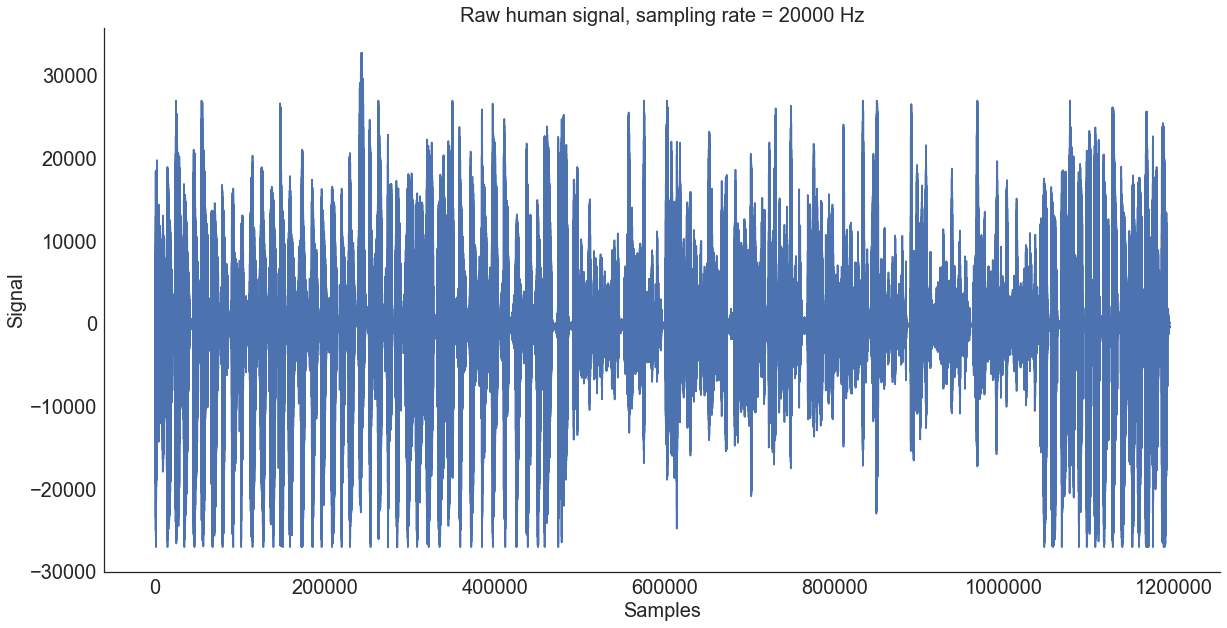

In [7]:
type = 'human'
with sns.axes_style('white'):
    plt.figure(figsize=(20, 10))
    sound_combined, fs = read_song_file(type)
    nsamples = len(sound_combined)
    sound_len_secs = nsamples / fs
    plt.plot(sound_combined)
    plt.xlabel('Samples', fontsize=20)
    plt.ylabel('Signal', fontsize=20)
    plt.title('Raw %s signal, sampling rate = %d Hz' % (type, fs), fontsize=20);
    sns.despine()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    
filename = 'waveform_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [8]:
#p=TW determines spatial and temporal resolution
#k runs from 1,2,...2p-1, are the orthogonal modes which serve as 'samples' of the fft

In [7]:
def my_spectrogram(x):
    '''TODO: Implement multitapering with multiple dpss functions'''
    start = 0
    seg = sound_combined[start:start+nperseg]
    np.fft.fft(seg * window).shape

In [8]:
def multitaper_spec(X, fs=20000, nadvance=200, slepian_len=500, nperseg=4096*4, NW=1):
    '''Perform a dpss multitapering
    Returns the spectrogram, frequency (f) and time ticks (t)'''

    # Use slepian window of width 0.3
    window = scipy.signal.slepian(M=slepian_len, width=NW / slepian_len)
    window = np.lib.pad(window, (0, nperseg - slepian_len), 'constant', constant_values=(0, 0))
    noverlap = len(window) - nadvance

    f,t,spectrogram = scipy.signal.spectrogram(X, fs, window=window, noverlap=noverlap)
    spectrogram = 20 * np.log10(spectrogram) #Units: dB
    
    return (f, t, spectrogram)

def sample_logspec(spectrogram, f, nsamples=256, fmin=100.0, fmax=4000.0):
    '''Sample the spectrogram tollect the required number of samples
    in frequency from fmin to fmax, logarithmically spaced
    Returns the spectrogram and the frequencies sampled'''
    # Frequencies to sample
    spacing = (np.log(fmax) - np.log(fmin)) / (nsamples - 1)
    logfreqs = np.log(fmin) + np.arange(nsamples) * spacing
    freqs = np.exp(logfreqs)
    

    # Sampled version
    row_ids = []
    for freq in freqs:
        row_ids.append(len(f[f < freq]))

    logspec = spectrogram[row_ids,:]
    return (logspec, freqs)

def format_func_spec(value, tick_number):
    '''Format tick marks for spectrogram plot'''
    if value >= len(freqs):
        label = max(freqs)
    else:
        label = freqs[int(value)]
    return int(np.round(label, -2))

def format_func_pcs(value, tick_number):
    '''Formatting axis ticks for the PC plot'''
    return value

In [15]:
fs, f, t, spectrogram = make_spectrogram_multifile('pda', 20)
logspec, freqs = sample_logspec(spectrogram, f, fmin=100.0, fmax=4000)


Reading file 0  of  20
5.2545625
Reading file 1  of  20
15.410250000000001
Reading file 2  of  20
20.307312500000002
Reading file 3  of  20
31.191312500000002
Reading file 4  of  20
36.1118125
Reading file 5  of  20
42.044624999999996
Reading file 6  of  20
51.0944375
Reading file 7  of  20
55.58725
Reading file 8  of  20
60.537749999999996
Reading file 9  of  20
68.67887499999999
Reading file 10  of  20
79.39249999999998
Reading file 11  of  20
88.78643749999998
Reading file 12  of  20
97.23824999999998
Reading file 13  of  20
107.76474999999998
Reading file 14  of  20
116.16312499999998
Reading file 15  of  20
122.06918749999998
Reading file 16  of  20
129.3349375
Reading file 17  of  20
138.17431249999998
Reading file 18  of  20
146.79649999999998
Reading file 19  of  20
154.67368749999997


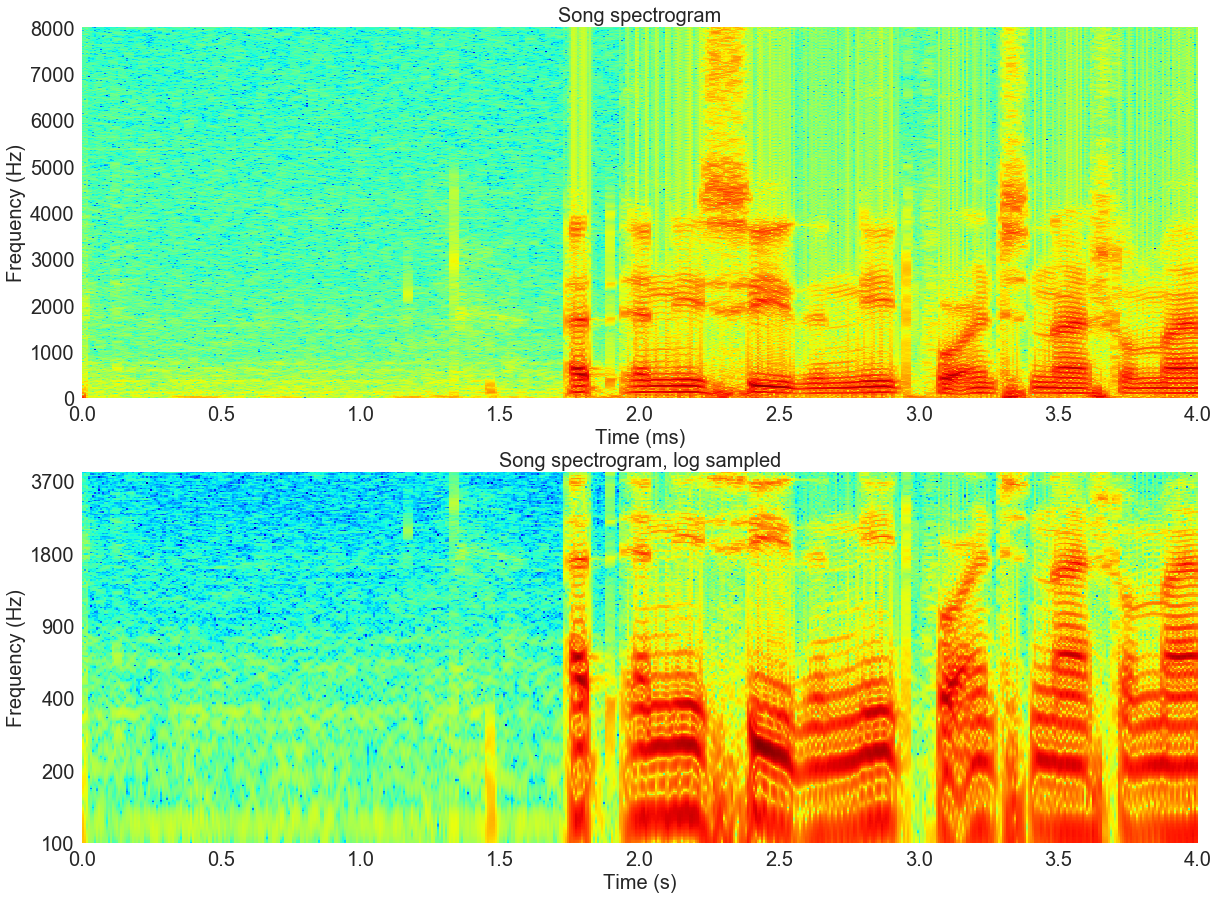

In [16]:
# Time and frequency ranges for plotting
fmin = 0
fmax = 8000 #Hz
tmin = 0
tmax = 4 #s
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,15))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (ms)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (s)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

Error: file exists. Skipped writing


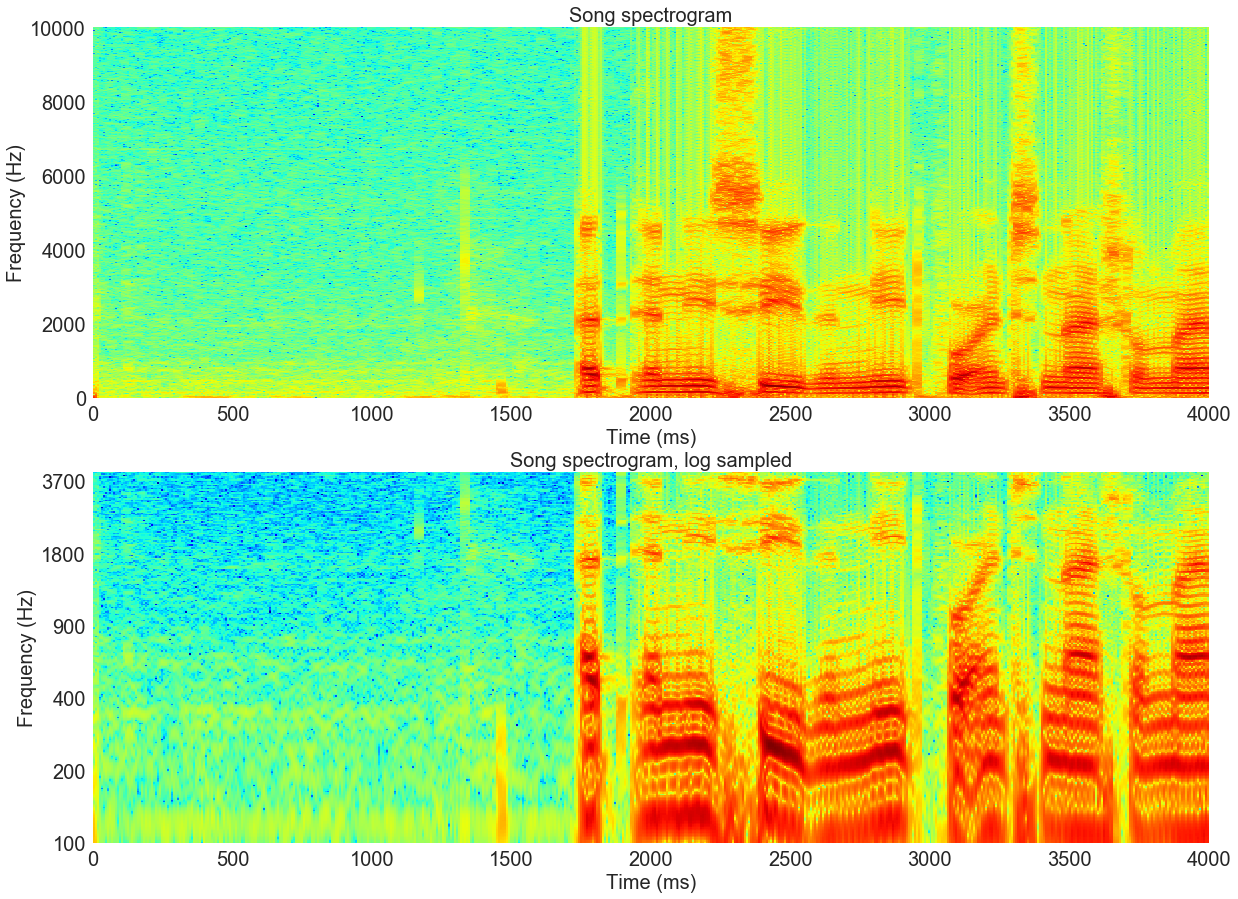

In [17]:
# Compute the spectrogram and log spectrogram
nadvance = 200
#f,t,spectrogram = multitaper_spec(sound_combined, fs=fs, nadvance=nadvance)
#logspec, freqs = sample_logspec(spectrogram, fmin=100.0, fmax=4000)

# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = 4000 #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin])
t_end = len(t[t<tmax/1000])


# Plot the spectrogram and log spectrogram
fig, ax = plt.subplots(2, 1, figsize=(20,15))
ax[0].imshow(np.flipud(spectrogram[f_start:f_end,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, fmin, fmax])
ax[0].grid(False)
ax[0].set_title('Song spectrogram', fontsize=20)
ax[0].set_xlabel('Time (ms)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].tick_params(axis='both', which='major', labelsize=20)

# For plotting
ax[1].imshow(np.flipud(logspec[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Song spectrogram, log sampled', fontsize=20)
ax[1].set_xlabel('Time (ms)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

filename = 'spectrogram_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')


## Segment the sound and perform PCA

(7680,)

In [18]:
# Segment into overlapping segments
spectrogram = logspec
segment_len = 30 #samples
segment_width = spectrogram.shape[0]
segment_step = 15 #samples
dt = segment_len * nadvance / fs * 1000 #length of each window in ms
segments_lst = []
for t_start in np.arange(0, spectrogram.shape[1] - segment_len, segment_step):
    segments_lst.append(spectrogram[:,t_start:(t_start + segment_len)])
    
# Do pca on each segment
X = np.zeros((segments_lst[0].shape[0] * segments_lst[0].shape[1], len(segments_lst)))
for idx, segment in enumerate(segments_lst):
    X[:,idx] = segment.ravel()    

# Mean subtract
Xmean = np.mean(X, axis=1)
Xmeans = np.tile(Xmean, (X.shape[1], 1))
X1 = X - Xmeans.T

# Perform pca with whitening
pca = PCA(n_components=200, whiten=True)
pca.fit(X1.T)
Y = pca.transform(X1.T).T 

pca2 = PCA(n_components=200, whiten=True)
pca2.fit(X.T)
Y2 = pca2.transform(X.T).T 

In [ ]:
# Cov matrix
cov = np.dot(X1dat.T, X1dat) / X1dat.shape[1]

# eig
#U, S, V = np.linalg.svd(cov)

In [ ]:
W, V = np.linalg.eig(cov)

In [ ]:
Y2 = np.dot(X1dat, V.T[:,:200])

In [ ]:
a=np.dot(Y2.T,Y2)
plt.imshow(a[:10,:10],cmap='jet')

In [ ]:
comp.shape

In [ ]:
V[:200,:].shape

Error: file exists. Skipped writing


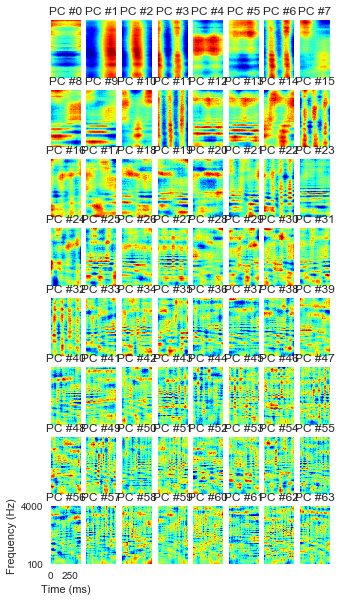

In [19]:
# Visualize principal components
n_show = 8 #number of rows to show. will show n_show x n_show pca components
fig, ax = plt.subplots(n_show, n_show, figsize=(5,10))
comp = pca.components_

for i in range(n_show):
    for j in range(n_show):
        idx = n_show*i + j
        component = comp[idx,:].reshape((segment_width, segment_len))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        ax[i][j].set_title('PC #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs))

filename = 'PCs_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [ ]:
b=Y2 - Y.T
plt.imshow(b[:10,:10],cmap='jet')

In [ ]:
spectrogram.shape

Error: file exists. Skipped writing


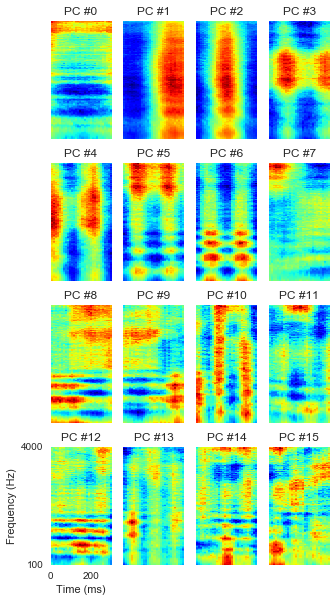

In [18]:
# Visualize principal components
n_show = 4 #number of rows to show. will show n_show x n_show pca components
fig, ax = plt.subplots(n_show, n_show, figsize=(5,10))
comp = pca.components_

for i in range(n_show):
    for j in range(n_show):
        idx = n_show*i + j
        component = comp[idx,:].reshape((segment_width, segment_len))
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(component), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        ax[i][j].set_title('PC #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs))

filename = 'PCs_human_171004.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Learning the sparse representation

In [53]:
# Set learning parameters
iters_s = 5 #number of iterations per s or A update
iters_A = 40
n_neurons = 800 #number of neurons
lamb = 0.1 #weight of sparsity constraint
tau = 0.2 #changed 0.1 to 0.01 10/1 #learning rate for s update
eta = 0.001 #learning rate for A update
theta = 0.001 #learning rate for A update (orthogonalizing component)

In [54]:
# Initialize and normalize A
A = np.random.rand(comp.shape[0], n_neurons)
A /= np.linalg.norm(A, axis=0)

In [70]:
nreps = 10
best_cost_s = np.inf
best_cost_A = np.inf
prev_cost_s = np.inf
prev_cost_A = np.inf
# Issue: In find_A: invalid value encountered in subtract
for i in range(nreps):
    print('#### Finding s, iteration ', i, '####')
    s,cost_s = find_s_batch(tau, A, Y, lamb, niter=iters_s, verbose=True)
    print('#### Finding A, iteration ', i, '####')

    A,cost_A = do_multiple_learn_steps(Y, A, s, eta=eta, theta=theta, nsteps=iters_A, verbose=False)
    A /= np.linalg.norm(A, axis=0)
    
    if cost_s <= prev_cost_s:
        tau *= 1.0
    else:
        tau *= 1.0
    
    if cost_A <= prev_cost_A:
        eta *= 1.0
        theta *= 1.0
    else:
        eta *= 1.0
        theta *= 1.0
    
    print('(tau, eta, theta) = ', tau, eta, theta)
    prev_cost_s = cost_s
    prev_cost_A = cost_A
        
    if i > 0 and cost_A < best_cost_A:
        best_cost_s = cost_s
        best_cost_A = cost_A
        best_s = s
        best_A = A

#### Finding s, iteration  0 ####
Starting iteration # 0 ...
Cost =  69967.567924 . tau = 0.21000000000000002
Starting iteration # 1 ...
Cost =  57870.032537 . tau = 0.22050000000000003
Starting iteration # 2 ...
Cost =  47307.0979474 . tau = 0.23152500000000004
Starting iteration # 3 ...
Cost =  41631.8260048 . tau = 0.24310125000000005
Starting iteration # 4 ...
Cost =  37017.3452493 . tau = 0.2552563125000001
Best cost =  37017.3452493
#### Finding A, iteration  0 ####
Best cost =  16165.72027
(tau, eta, theta) =  0.2 0.001 0.001
#### Finding s, iteration  1 ####
Starting iteration # 0 ...
Cost =  69947.3402902 . tau = 0.21000000000000002
Starting iteration # 1 ...
Cost =  57799.5300834 . tau = 0.22050000000000003
Starting iteration # 2 ...
Cost =  47176.3031722 . tau = 0.23152500000000004
Starting iteration # 3 ...
Cost =  41467.4946965 . tau = 0.24310125000000005
Starting iteration # 4 ...
Cost =  36812.1233017 . tau = 0.2552563125000001
Best cost =  36812.1233017
#### Finding A, 

In [28]:
A,cost_A = do_multiple_learn_steps(Y, A, s, eta=0.001, theta=theta, nsteps=5, verbose=False)
print(cost_A)

Best cost =  50613.9434018
50613.9434018


In [24]:
s

array([[ 0.        ,  0.        ,  0.08502695, ...,  0.02476894,
         0.        ,  0.        ],
       [ 0.        ,  0.09286686,  0.49429482, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.55634316,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.05214971,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.03017465,
         0.        ,  0.        ]])

In [61]:
s,cost_s = find_s_batch(0.5, A, Y, lamb, niter=15, verbose=True)

Starting iteration # 0 ...
Cost =  26899.8478694 . tau = 0.525
Starting iteration # 1 ...
Cost =  61826.0608181 . tau = 0.2625
Starting iteration # 2 ...
Cost =  40587.0259421 . tau = 0.275625
Starting iteration # 3 ...
Cost =  36282.308238 . tau = 0.28940625000000003
Starting iteration # 4 ...
Cost =  33418.2291447 . tau = 0.30387656250000006
Starting iteration # 5 ...
Cost =  31415.7281744 . tau = 0.3190703906250001
Starting iteration # 6 ...
Cost =  30522.3742797 . tau = 0.3350239101562501
Starting iteration # 7 ...
Cost =  29701.1754433 . tau = 0.3517751056640626
Starting iteration # 8 ...
Cost =  29395.4999607 . tau = 0.36936386094726575
Starting iteration # 9 ...
Cost =  28928.9017239 . tau = 0.38783205399462906
Starting iteration # 10 ...
Cost =  28914.4453635 . tau = 0.4072236566943605
Starting iteration # 11 ...
Cost =  28608.450893 . tau = 0.42758483952907855
Starting iteration # 12 ...
Cost =  28689.9441727 . tau = 0.21379241976453928
Starting iteration # 13 ...
Cost =  2986

In [ ]:
cost_s

In [ ]:
best_s.shape

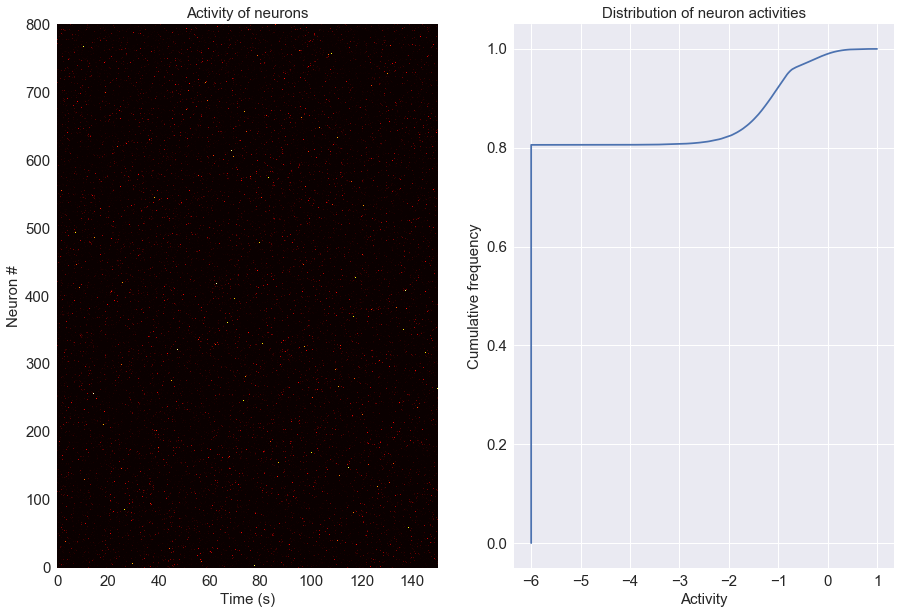

In [64]:
# Visualize the activities of neurons
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sound_len_secs = 150

ax[0].imshow(best_s, cmap='hot', extent=[0, sound_len_secs, 0, n_neurons], aspect='auto')
#fig.colorbar(ax[0])
ax[0].set_xlabel('Time (s)', fontsize=15)
ax[0].set_ylabel('Neuron #', fontsize=15)
ax[0].grid(False)
ax[0].set_title('Activity of neurons', fontsize=15);
ax[0].tick_params(axis='both', which='major', labelsize=15)

#ax[0].xticks(fontsize=15)
#ax[0].yticks(fontsize=15);

s_activities = best_s.ravel()
ax[1].plot(np.sort(np.log10(s_activities + 10**-6)), np.arange(len(s_activities)) / len(s_activities))
ax[1].set_xlabel('Activity', fontsize=15)
ax[1].set_ylabel('Cumulative frequency', fontsize=15)
ax[1].set_title('Distribution of neuron activities', fontsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)



filename = 'neurons_activity_human_171005_20filespda.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

## Reconstruction of the spectrogram

In [66]:
def reconstruct_from_A_s(A, S, pca, shape, segment_width, segment_len, Y=None):
    '''Reconstruct the spectrogram, given a dictionary A of receptive fields,
    and s: the activity of neurons'''
    Y = np.dot(A, S)
    Y_inverted = pca.inverse_transform(Y.T).T
    recons = np.zeros(shape)

    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

def reconstruct_from_pca(Y, pca, shape, segment_width, segment_len):
    '''Reconstruct the spectrogram, given its pca projection'''
    recons = np.zeros(shape)
    Y_inverted = pca.inverse_transform(Y.T).T
    #Y_inverted = np.dot(comp.T, Y)
    for ncol in range(Y.shape[1]):
        segment = np.reshape(Y_inverted[:,ncol], (segment_width, segment_len))
        start = ncol * segment_step
        recons[:,start:(start + segment_len)] += segment
    return recons

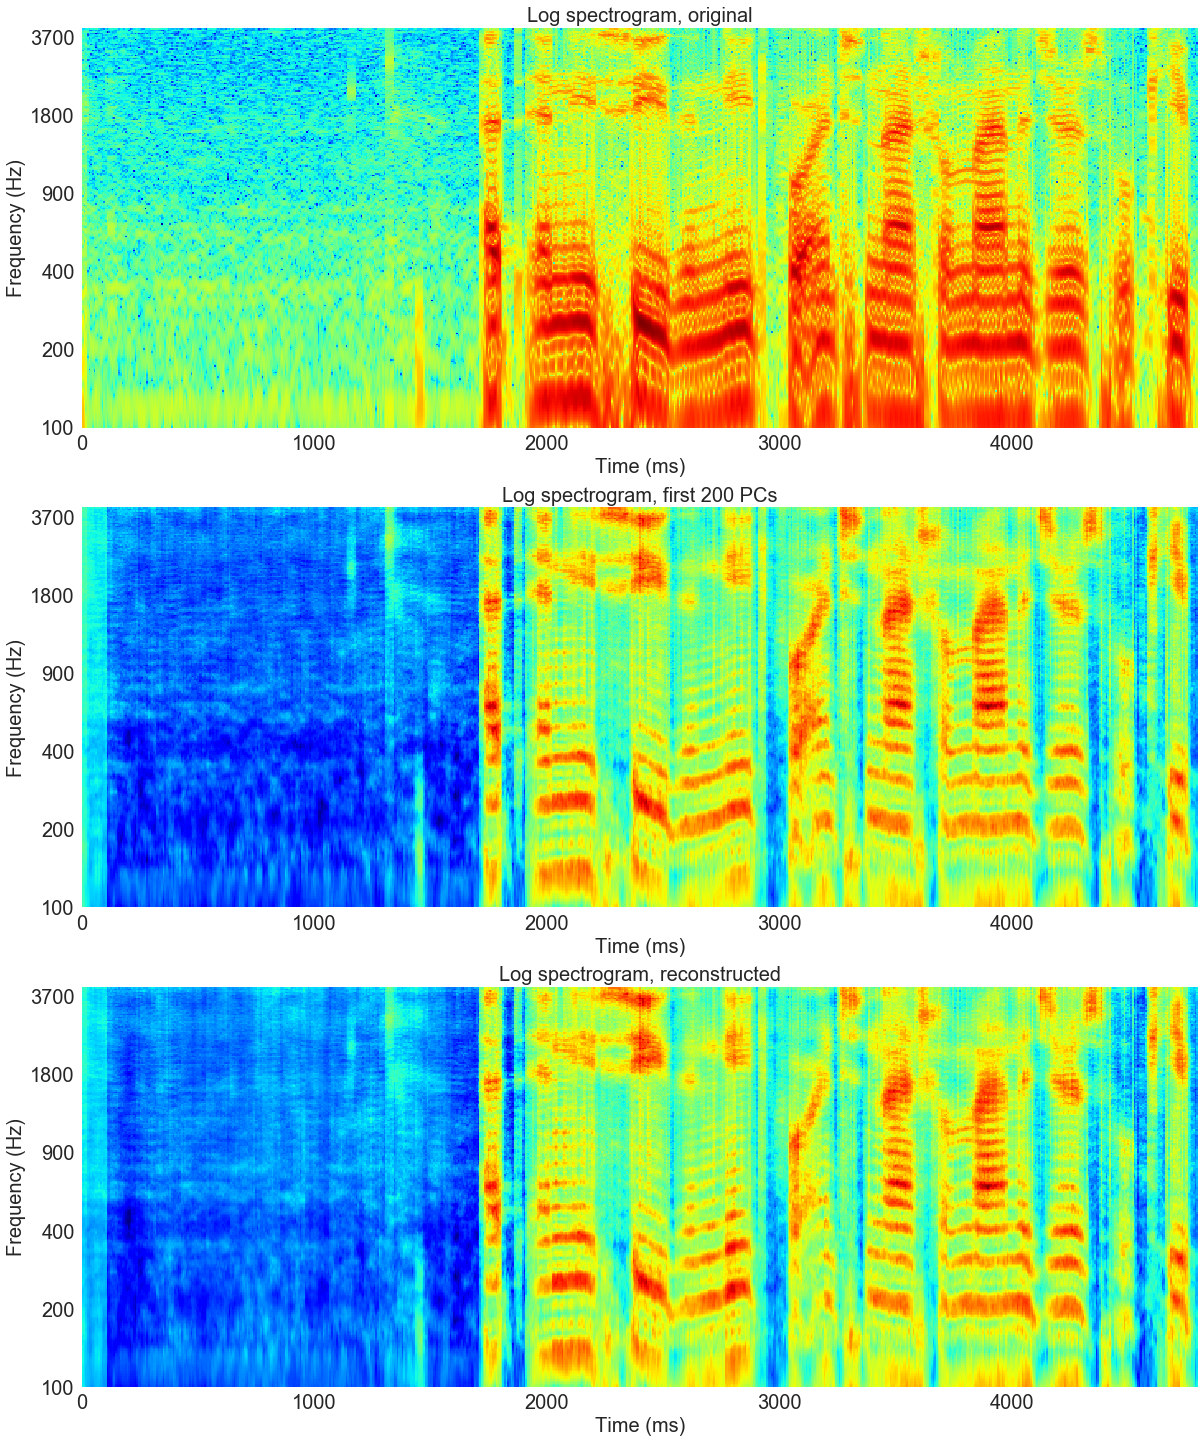

In [68]:
recons = reconstruct_from_A_s(best_A, best_s, pca, spectrogram.shape, segment_width, segment_len)
recons_pca = reconstruct_from_pca(Y, pca, spectrogram.shape, segment_width, segment_len)

# Time and frequency ranges for plotting
fmin = 0
fmax = 10000 #Hz
tmin = 0
tmax = 4800 #ms
f_start = len(f[f<fmin])
f_end = len(f[f<fmax])
t_start = len(t[t<tmin/1000])
t_end = len(t[t<tmax/1000])

logspec_n = (logspec - np.mean(logspec)) / np.std(logspec)
recons_n = (recons - np.mean(recons)) / np.std(recons)

# For plotting
fig, ax = plt.subplots(3, 1, figsize=(20,25))
ax[0].imshow(np.flipud(spectrogram[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[0].grid(False)
ax[0].set_title('Log spectrogram, original', fontsize=20)
ax[0].set_xlabel('Time (ms)', fontsize=20)
ax[0].set_ylabel('Frequency (Hz)', fontsize=20);
ax[0].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[0].tick_params(axis='both', which='major', labelsize=20)



ax[1].imshow(np.flipud(recons_pca[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[1].grid(False)
ax[1].set_title('Log spectrogram, first 200 PCs', fontsize=20)
ax[1].set_xlabel('Time (ms)', fontsize=20)
ax[1].set_ylabel('Frequency (Hz)', fontsize=20);
ax[1].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[1].tick_params(axis='both', which='major', labelsize=20)

# Plot the original vs the reconstructed songs
ax[2].imshow(np.flipud(recons_n[:,t_start:t_end]), cmap='jet', aspect='auto',
           extent=[tmin, tmax, 0, len(freqs)])
ax[2].grid(False)
ax[2].set_title('Log spectrogram, reconstructed', fontsize=20)
ax[2].set_xlabel('Time (ms)', fontsize=20)
ax[2].set_ylabel('Frequency (Hz)', fontsize=20);
ax[2].yaxis.set_major_formatter(plt.FuncFormatter(format_func_spec))
ax[2].tick_params(axis='both', which='major', labelsize=20)



filename = 'recons_comparison_human_171006_200filespda.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')
    

## Visualize the receptive fields of the neurons

Error: file exists. Skipped writing


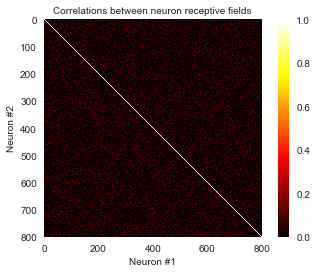

In [69]:
# Check the orthogonality of neurons
A_inv = np.dot(comp.T, best_A)
corr = np.dot(A_inv.T, A_inv)
plt.imshow(corr, cmap='hot')
plt.grid(False)
plt.colorbar()
plt.clim(0, 1)
plt.title('Correlations between neuron receptive fields', fontsize=10)
plt.xlabel('Neuron #1', fontsize=10)
plt.ylabel('Neuron #2', fontsize=10)

filename = 'correlations_human_171005.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [ ]:
plt.imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
plt.colorbar()

In [39]:
c1 = A[:,0]
c1_inv = pca.inverse_transform(c1)

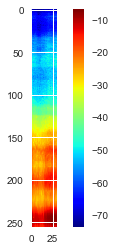

In [55]:
c1_im = np.reshape(c1_inv, (segment_width, segment_len))
plt.imshow(np.flipud(c1_im), cmap='jet')
plt.colorbar()

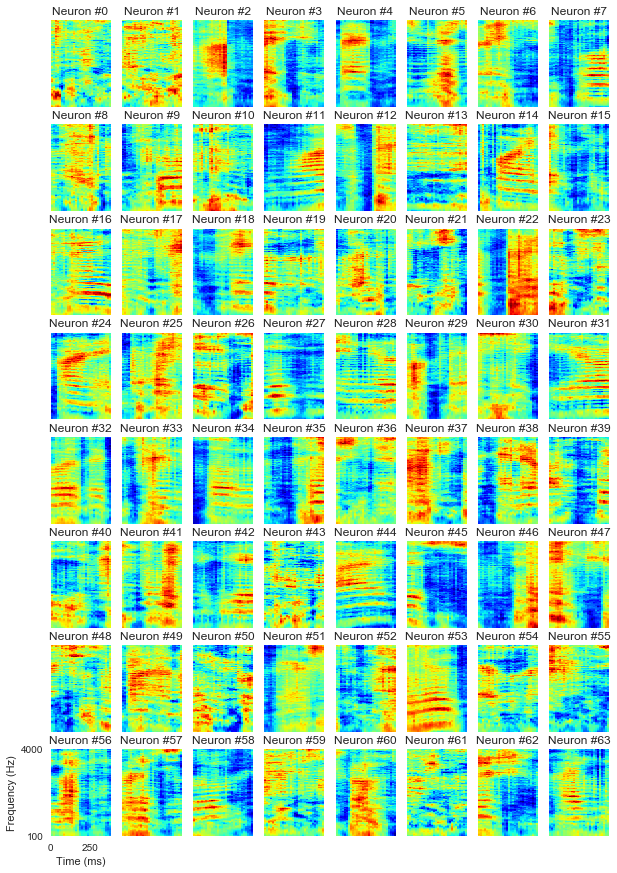

In [36]:
n_show = 8
A_inverted = pca.inverse_transform(best_A.T).T
fig, ax = plt.subplots(n_show, n_show, figsize=(10,15))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
for i in range(n_show):
    for j in range(n_show):
        A_col = A[:,n_show*i + j]
        A_col_inv = pca.inverse_transform(A_col)
        A_inv_im = np.reshape(A_col_inv, (segment_width, segment_len))
        #seg = A_inverted[:,n_show*i + j].reshape((segment_width, segment_len))
        
        # Filter
        #filt = scipy.ndimage.filters.gaussian_filter(seg, sigma=2)
        
        idx = n_show*i + j
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(A_inv_im), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].set_yscale('log')
        ax[i][j].set_title('Neuron #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 
filename = 'receptive_fields_human_1710045_20filesPDA.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')

In [76]:
A.shape

(200, 800)

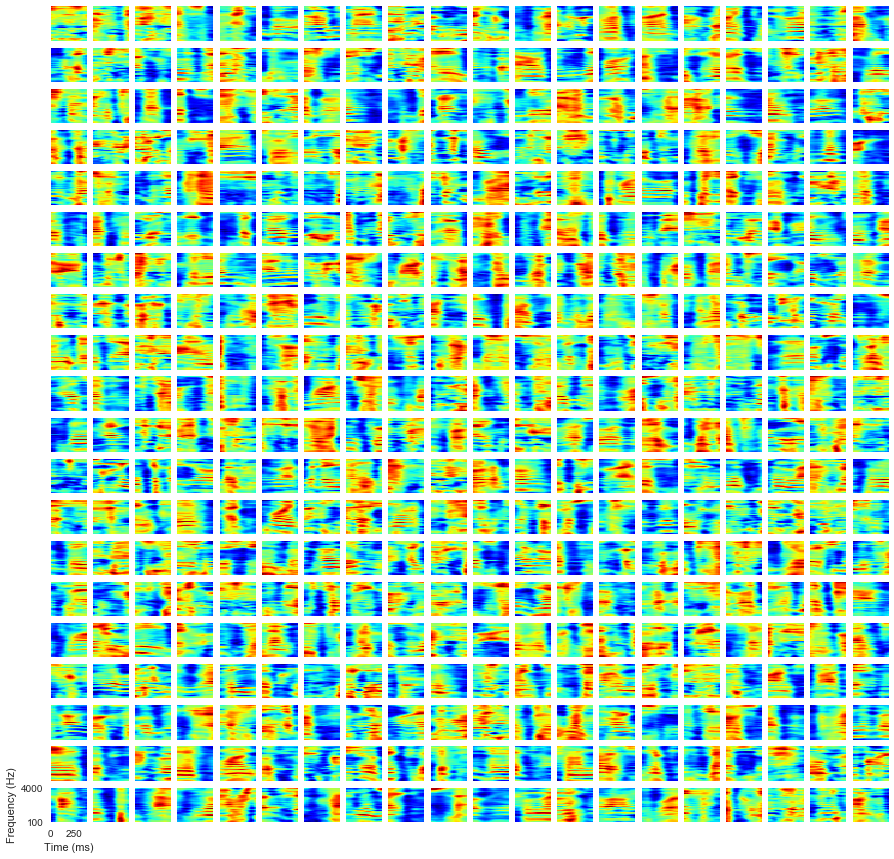

In [81]:
n_show = 20
A_inverted = pca.inverse_transform(best_A.T).T
fig, ax = plt.subplots(n_show, n_show, figsize=(15,15))
fig.subplots_adjust(left=None, bottom=None, right=None, top=None,
            wspace=None, hspace=None)
for i in range(n_show):
    for j in range(n_show):
        A_col = A[:,n_show*i + j]
        A_col_inv = pca.inverse_transform(A_col)
        A_inv_im = np.reshape(A_col_inv, (segment_width, segment_len))
        #seg = A_inverted[:,n_show*i + j].reshape((segment_width, segment_len))
        
        # Filter
        filt = scipy.ndimage.filters.gaussian_filter(A_inv_im, sigma=2)
        
        idx = n_show*i + j
        ax[i][j].grid(False)
        ax[i][j].imshow(np.flipud(filt), cmap='jet', aspect='auto', extent=[0, dt, 100, 4000])
        #ax[i][j].set_yscale('log')
        #ax[i][j].set_title('Neuron #' + str(idx))
        ax[i][j].set_ylim([100, 4000])
        if i != n_show - 1 or j != 0:
            ax[i][j].set(xticklabels=[], yticklabels=[])
        else:
            ax[i][j].set_xlabel('Time (ms)')
            ax[i][j].set_ylabel('Frequency (Hz)')
            #ax[i][j].yaxis.set_major_locator(plt.LogLocator(numticks=5))
            ax[i][j].yaxis.set_major_locator(plt.FixedLocator([100, 4000]))
            ax[i][j].yaxis.set_major_formatter(plt.FuncFormatter(format_func_pcs)) 
filename = 'receptive_fields_human_1710045_20filesPDAb.pdf'
if not os.path.isfile(filename):
    plt.savefig(filename)
else:
    print('Error: file exists. Skipped writing')